## Import thư viện

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets

2021-11-29 03:21:55.331341: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-29 03:21:55.331454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-11-29 03:21:59.779730: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-29 03:21:59.782167: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-29 03:21:59.782195: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-29 03:21:59.782221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0467d8f39983): /proc/driver/nvidia/version does not exist
2021-11-29 03:21:59.785774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [4]:
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
WIDTH = 480
HEIGHT = 480
CHANNELS = 3
LEARNING_RATE = 0.001
CLASSES = 6
SEED = 32
top_dropout_rate = 0.2

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('fgvc8aug')
TRAIN_PATH = GCS_DS_PATH + "/data_full_augmentation_images/data_full_augmentation/images/"
print(GCS_DS_PATH)

gs://kds-2bef73751704c13199297869fb5ffba210239a19cc19f538e88a583f


In [6]:
final_model = 'FGVC8-VGG19t.h5'
hist_path = 'FGVC8-VGG19.log'
train_image = '../input/fgvc8aug/data_full_augmentation_images/data_full_augmentation/images'
train_df = pd.read_csv('../input/fgvc8aug/data.csv', )

In [7]:
train_df = train_df[["image", "labels"]]
mlb = MultiLabelBinarizer().fit(train_df.labels.apply(lambda x : x.split()))
labels = pd.DataFrame(mlb.transform(train_df.labels.apply(lambda x : x.split())), columns = mlb.classes_)

labels = pd.concat([train_df['image'], labels], axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,c0c81ef5083faf1e_aug.jpg,0,1,0,0,0,0
1,c0c8c7270f638f9e_aug.jpg,0,0,1,0,0,0
2,c0c8cbbd163772d4_aug.jpg,0,1,0,0,0,0
3,c0c8679f29e519bc_aug.jpg,0,0,0,0,1,0
4,c0cac1de1be46f64_aug.jpg,1,0,0,0,0,0


In [8]:
def format_path(st):
    return TRAIN_PATH + st

train_paths = labels.image.apply(format_path).values

train_labels = np.float32(labels.loc[:, 'complex':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [9]:
def process_img(filepath,label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

In [10]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(process_img, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(process_img, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

## Get model

In [11]:
def get_model():
    VGG19_MODEL = tf.keras.applications.VGG19(weights='imagenet' ,include_top=False, input_shape=(HEIGHT, WIDTH, 3))
    
    x=VGG19_MODEL.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(256,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(128,activation='relu')(x)
    prediction=Dense(6,activation='sigmoid')(x)

    model=Model(inputs=VGG19_MODEL.input, outputs=prediction)
    
    return model

In [12]:
with strategy.scope():
    model = get_model()

    f1_score = tfa.metrics.F1Score(num_classes=6, threshold=0.4, average='micro')
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005) , loss='binary_crossentropy', metrics=[f1_score, 'accuracy'])

80142336/80134624 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0     

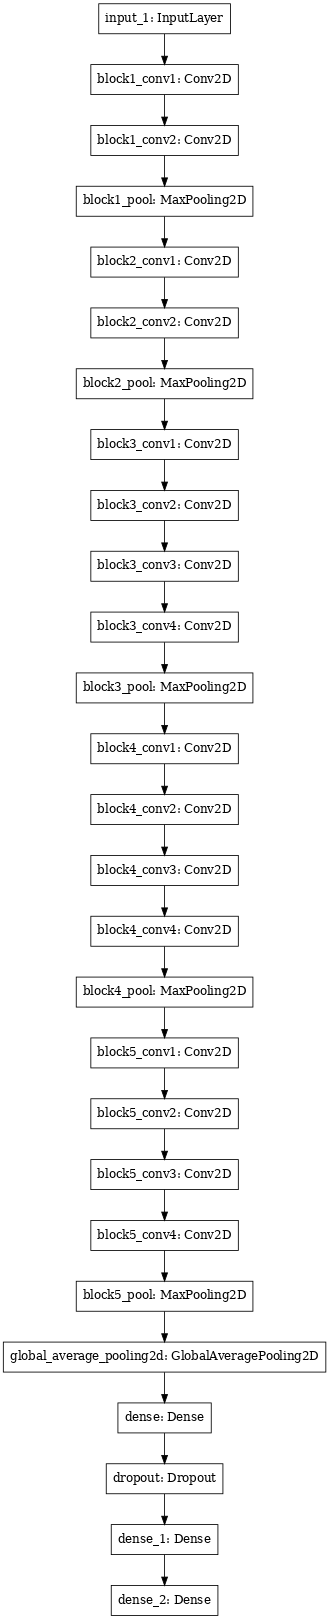

In [14]:
tf.keras.utils.plot_model(model, dpi=60)

## Trainning

In [15]:
checkpoint = ModelCheckpoint(
    final_model,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 3,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [16]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [17]:
params = model.fit(
    train_dataset, 
    validation_data = valid_dataset, 
    epochs = EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [lr_schedule, early_stopping, checkpoint, CSVLogger(hist_path)]
)

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
246/246 [==============================] - 1590s 6s/step - loss: 0.4357 - f1_score: 0.3105 - accuracy: 0.3511 - val_loss: 0.2214 - val_f1_score: 0.7423 - val_accuracy: 0.7480

Epoch 00001: val_accuracy improved from -inf to 0.74803, saving model to FGVC8-VGG19t.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
246/246 [==============================] - 701s 3s/step - loss: 0.2918 - f1_score: 0.6280 - accuracy: 0.6364 - val_loss: 0.1469 - val_f1_score: 0.8435 - val_accuracy: 0.8566

Epoch 00002: val_accuracy improved from 0.74803 to 0.85663, saving model to FGVC8-VGG19t.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
246/246 [==============================] - 722s 3s/step - loss: 0.1601 - f1_score: 0.8260 - accuracy: 0.8272 - val_loss: 0.1305 - val_f1_score: 0.8537 - val_accuracy: 0.8670

Epoch 00003: val_accuracy improved from 0.85663 